# Notebook 1 — The ML Onramp

This notebook establishes a bridge between numerical analysis (interpolation, least squares) and machine learning (gradient descent, neural networks). We follow a single unifying framework:

$$\boxed{\text{Data} \;\rightarrow\; \text{Model} \;\rightarrow\; \text{Loss} \;\rightarrow\; \text{Optimizer}}$$

The primary machine learning library for this demonstration is PyTorch https://pytorch.org/ . This is one of the more popular machine learning libraries for research.

**Goals:**
- See the problem of "overfitting" in the context of polynomial interpolation on Runge's function
- Redefine the problem of polynomial interpolation as a machine learning optimization problem with a least squares loss
- Familiarize ourselves with PyTorch tools for working with data, models, losses, and optimizers
- Solve the anlytic solution and compare to iterative gradient descent
- Understand stochastic gradient descent (SGD) and the role of mini-batches
- Derive abstractions for neural network layers and activation functions
- Implement Single Layer Perceptron (SLP) and Multi-Layer Perceptron (MLP) models

---
## A Starting Problem: The Runge Function

The Runge function is a notable example in numerical anaylsis of a function that is smooth and well-behaved:

$$f(x) = \frac{1}{1 + 25x^2}, \qquad x \in [-1, 1].$$

The *Runge phenomenon* where the error of regular spaced polynomial interpolation at a point $x$ is given by
$$e_N(x) = f(x) - p_N(x) = (x-x_0)...(x-x_N) \frac{f^{(N+1)}(\xi)}{(N+1)!}$$
The function has poles at $\pm i/5$, so the radius of convergence of the Taylor series is $1/5$. For $N$ regularly spaced nodes and polynomial interpolation, the error grows without bounds. We can use Chebyshev nodes or interpolating splines to improve the results, but let's take a machine learning perspective instead.

**Idea**
The poor interpolation is a consequence of "overfitting" to the data at the interpolation nodes due to the construction of the mathematical model and the choice of interpolation nodes. Our goal then is to find a **parametric model** $f(x;\theta)$ that minimizes a notion of error over the entire interval, not just at the interpolation nodes. 

In many practical settings, we may be working with experimental or empirical data which is susceptible to noise. We define a dataset of $N$ input-output pairs $\{(x_i, y_i)\}_{i=1}^N$ where $y_i = f(x_i) + \epsilon_i$ and $\epsilon_i$ is some noise term assumed to be Gaussian. In our case, we can generate this dataset by sampling points from the Runge function and adding some random noise.

In [101]:
# Plotting style
import matplotlib.pyplot as plt
plt.style.use('./academic.mplstyle')
import seaborn as sns
sns.set_context("talk", font_scale=0.6)

#### A Familiar Approach: Polynomial Interpolation

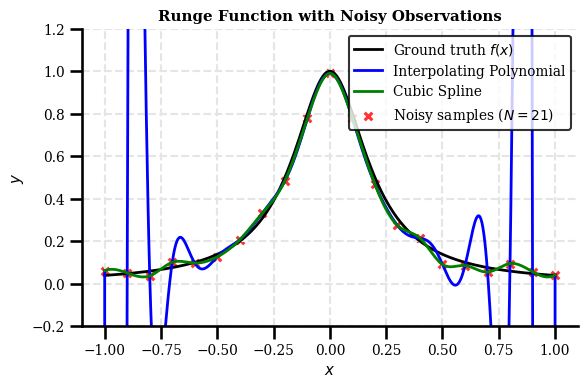

In [102]:
import numpy as np
import matplotlib.pyplot as plt

# --- Ground truth ---
def runge(x):
    """Runge function: f(x) = 1 / (1 + 25x^2)"""
    return 1.0 / (1.0 + 25.0 * x**2)

def noise(x, noise_std=0.05):
    """Additive Gaussian noise"""
    return noise_std * np.random.randn(*x.shape)

# --- Generate noisy training data ---
np.random.seed(67)
N = 21                            
x_train = np.linspace(-1, 1, N)  # Equidistant nodes
noise_std = 0.02
y_train = runge(x_train) + noise(x_train, noise_std)  # y_i = f(x_i) + epsilon

# --- Dense grid for plotting ---
x_plot = np.linspace(-1, 1, 500)
y_true = runge(x_plot)

# --- Interpolating polynomial (for demonstration) ---
from scipy.interpolate import BarycentricInterpolator
interpolator = BarycentricInterpolator(x_train, y_train)
y_interp = interpolator(x_plot)

# --- Cubic Splines ---
from scipy.interpolate import CubicSpline
spline = CubicSpline(x_train, y_train)
y_spline = spline(x_plot)

# --- Plot ---
plt.figure(figsize=(6,4))
plt.plot(x_plot, y_true, 'k-', lw=2, label='Ground truth $f(x)$')
plt.plot(x_plot, y_interp, 'b-', lw=2, label='Interpolating Polynomial')
plt.plot(x_plot, y_spline, 'g-', lw=2, label='Cubic Spline')
# Set scatter to red Xs
plt.scatter(x_train, y_train, s=30, alpha=0.8, color='r', marker='x', label=f'Noisy samples ($N={N}$)')
# Set scale for y-axis 
plt.ylim(-0.2, 1.2)
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.title('Runge Function with Noisy Observations')
plt.legend(); plt.tight_layout(); plt.show()

# A Machine Learning Approach
What if we reframe the problem as a statistical machine learning task? The higher order polynomial interpolation was "overfitting", what if we fit a lower-order approximating polynomial of degree $M<N$ to the data instead? We sacrifice perfect fitting at the nodes but hope to achieve better generalization across the entire interval. Below is a demonstration of this approach using PyTorch

## Model

We suppose that the underlying function $f_\theta(x)$ is a polynomial of degree $M<N$ with coefficients $\theta = [\theta_0, \theta_1, ..., \theta_M]$:
$$f(x; \theta) = \theta_0 + \theta_1 x + \theta_2 x^2 + ... + \theta_M x^M.$$
Then to solve for all the estimated $\hat y_i$ at the training points, we use the Vandermonde matrix $X$ of the input data:
$$X = \begin{bmatrix} 1 & x_1 & x_1^2 & \cdots & x_1^M \\ 1 & x_2 & x_2^2 & \cdots & x_2^M \\ \vdots & & & & \vdots \\ 1 & x_N & x_N^2 & \cdots & x_N^M \end{bmatrix} \in \mathbb{R}^{N \times (M+1)}$$
$$\hat y = [\hat y_1,\hat  y_2, ..., \hat y_N]^T = X\theta + \epsilon$$

## Loss Function: Least Squares
We use least squares loss to quantify the error at the training points or nodes:
$$\mathcal{L}(\theta) = \frac{1}{N} \sum_{i=1}^N (y_i - f(x_i; \theta))^2 = \frac{1}{N} \|X\theta-\mathbf{y}\|_2^2$$

### A Bit of Theory: (Skip this if you want to get to the code)

We suppose that we have some samples $\{(x_i, y_i)\}_{i=1}^N$ where $y_i = f(x_i) + \epsilon_i$. If we assume the noise $\epsilon_i$ is independent and identically distributed (i.i.d.) according to a Gaussian distribution $\mathcal{N}(0, \sigma^2)$, the probability of observing a single point $y_i$ given our model $f_\theta(x)$ is:
$$p(y_i | x_i; \theta) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left( -\frac{(y_i - f_\theta(x_i))^2}{2\sigma^2} \right)$$
The **Likelihood** of observing the entire dataset is the product of these individual probabilities:
$$L(\theta) = \prod_{i=1}^N p(y_i | x_i; \theta) = \left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)^N \exp\left( -\sum_{i=1}^N \frac{(y_i - f_\theta(x_i))^2}{2\sigma^2} \right)$$
To find the best parameters $\theta$, we maximize the **Log-Likelihood** (MLE). Notice that maximizing the log-likelihood is equivalent to minimizing the negative term in the exponent:
$$\arg\max_\theta \ln L(\theta) = \arg\min_\theta \sum_{i=1}^N (y_i - f_\theta(x_i))^2 = \arg\min_\theta \left\| \mathbf{y} - X\theta \right\|^2$$
Maximizing the likelihood of data with Gaussian noise is mathematically equivalent to solving for the Least Squares solution. This loss function is a probabilistic interpretation of the data, noise, and model.

## Analytic Optimizer: Normal Equations

$$\mathcal{L}(\theta) = \|X\theta - y\|_2^2.$$

Setting $\nabla_\theta \mathcal{L} = 0$ yields the closed-form solution:

$$\boxed{\theta^* = (X^\top X)^{-1} X^\top y}$$

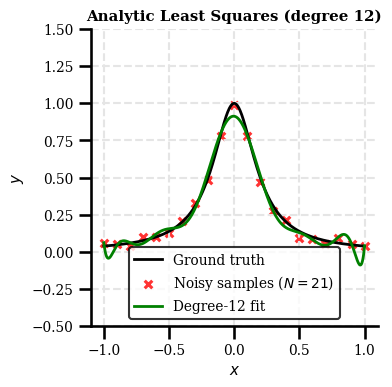

In [103]:
def analytic_poly_fit(x, y, degree):
    """Solve for polynomial coefficients via the Normal Equation."""
    X = np.vander(x, N=degree + 1, increasing=True)  # Vandermonde matrix
    theta = np.linalg.solve(X.T @ X, X.T @ y)        # (X^T X)^{-1} X^T y
    return theta

def poly_eval(x, theta):
    """Evaluate polynomial with coefficient vector theta."""
    X = np.vander(x, N=len(theta), increasing=True)
    return X @ theta

deg = 12
theta = analytic_poly_fit(x_train, y_train, deg)
y_fit = poly_eval(x_plot, theta)

plt.figure(figsize=(4,4))
plt.plot(x_plot, y_true, 'k-', lw=2, label='Ground truth')
plt.scatter(x_train, y_train, s=30, alpha=0.8, color='r', marker='x', label=f'Noisy samples ($N={N}$)')
plt.plot(x_plot, y_fit, 'g-', lw=2, label=f'Degree-{deg} fit')
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.title(f'Analytic Least Squares (degree {deg})')
plt.ylim(-0.5, 1.5)
plt.legend()

plt.tight_layout(); plt.show()

## Optimizer: Gradient Descent

We might not always have a closed analytic solution to an optimization problem. In such cases, we can use iterative optimization methods to find a local minimum of the loss function. One of the most common iterative optimization algorithms is gradient descent.

**Idea:** Use a starting approximation for $\theta$ and iteratively improve it by following the negative gradient of the loss function. 

$$\theta \leftarrow \theta - \eta \, \nabla_\theta \mathcal{L}(\theta)$$
We call $\eta$ the **learning rate** which controls the step size of each update.

# Using Pytorch
PyTorch automates this with four building blocks:

| Pillar | What it does | PyTorch API |
|--------|-------------|-------------|
| **Data** | Holds inputs & targets as tensors | `torch.tensor(...)` |
| **Model** | Parametric function $f(x;\theta)$ | `nn.Module` with `nn.Parameter` |
| **Loss** | Measures prediction error | `nn.MSELoss()` |
| **Optimizer** | Updates $\theta$ using $\nabla\mathcal{L}$ | `torch.optim.SGD(...)` |

### Data
PyTorch provides a convenient way to handle datasets through the `torch.utils.data.Dataset` class. This handles the loading and batching of large-scale datasets, including shuffling and parallel loading onto multiple CPUs or GPUs. We can create a custom dataset wrapper around the generated noise-corrupted Runge function data and then use a `DataLoader` to iterate through the data.

In [104]:
import torch
from torch.utils.data import Dataset, DataLoader

class RungeDataset(Dataset):
    """PyTorch Dataset wrapping y=f(x) function samples."""
    def __init__(self, x, y):
        # Convert numpy arrays to float32 tensors and add a feature dimension
        self.x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)  # (N,) -> (N, 1)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # (N,) -> (N, 1)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# --- Create dataset ---
train_dataset = RungeDataset(x_train, y_train)
print(f"First sample point: {train_dataset[0]}")

First sample point: (tensor([-1.]), tensor([0.0610]))


### Define the Model

We wrap the *same* polynomial model $f(x;\theta) = \theta_0 + \theta_1 x + \cdots + \theta_n x^n$ inside a `nn.Module`. Declaring coefficients as `nn.Parameter` tells PyTorch to **track gradients** for those tensors using automatic differentiation.

In [105]:
import torch
import torch.nn as nn

class PolynomialModel(nn.Module):
    """Learnable polynomial: y = theta_0 + theta_1*x + ... + theta_n*x^n"""
    def __init__(self, degree):
        super().__init__()
        # Initialize the learnable parameters
        self.coeffs = nn.Parameter(torch.randn(degree + 1) * 0.01)
        
    @property
    def degree(self):
        return len(self.coeffs) - 1

    def forward(self, x):
        # Build powers: [x^0, x^1, ..., x^n]
        powers = torch.stack([x ** k for k in range(len(self.coeffs))], dim=-1)
        return powers @ self.coeffs

# Quick sanity check
model_test = PolynomialModel(degree=5)
print("Learnable parameters:", [p.shape for p in model_test.parameters()])
print("Total parameters:", sum(p.numel() for p in model_test.parameters()))

Learnable parameters: [torch.Size([6])]
Total parameters: 6


### Loss & Optimizer

- **Loss:** `nn.MSELoss()` computes $\frac{1}{N}\sum_i (\hat y_i - y_i)^2$ — exactly the least-squares objective.
- **Optimizer:** `torch.optim.SGD` implements the gradient update $\theta \leftarrow \theta - \eta\nabla\mathcal{L}$. The learning rate $\eta$ controls the step size.

### The Training Loop

Every iteration of (stochastic) gradient descent follows the same recipe:

| Code Line | Step | Purpose | Mathematical Concept |
| :--- | :--- | :--- | :--- |
| `optimizer.zero_grad()` | **Reset** | Clears out the gradients from the previous iteration to prevent them from accumulating. | $\nabla_{\theta} = 0$ |
| `model_gd(x)` | **Forward Pass** | Passes a batch of $x$ through the model to calculate the predicted $\hat{y}$. | $\hat{y} = f(x; \theta)$ |
| `loss.backward()` | **Backward Pass** | Uses autograd to compute the gradient of the loss function with respect to the parameters. | $\nabla_{\theta} \mathcal{L}$ |
| `optimizer.step()` | **Update** | Adjusts the model parameters (weights and biases) in the direction that minimizes loss. | $\theta \leftarrow \theta - \eta \nabla_{\theta} \mathcal{L}$ |

If we pass *all* $N$ samples every iteration, this is **full-batch gradient descent** (GD).

In [106]:
# --- Instantiate data, model, loss, optimizer ---
torch.manual_seed(67)  # For reproducibility
train_dataset = RungeDataset(x_train, y_train)
train_loader  = DataLoader(train_dataset, batch_size=21, shuffle=True)
model_gd = PolynomialModel(degree = 12)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model_gd.parameters(), lr=0.5)

# --- Full-batch Gradient Descent training loop ---
num_iterations = 2000
loss_history_gd = []

for epoch in range(num_iterations):
    x_batch = train_dataset.x  # (N, 1)
    y_batch = train_dataset.y  # (N, 1)
    y_pred = model_gd(x_batch)           # Forward pass
    loss = criterion(y_pred, y_batch)     # Compute loss

    optimizer.zero_grad()                  # Zero out accumulated gradients
    loss.backward()                        # Backpropagation (autograd)
    optimizer.step()                       # Parameter update

    loss_history_gd.append(loss.item())
    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1:>5d}/{num_iterations}  |  Loss = {loss.item():.6f}")

print(f"\nFinal GD loss: {loss_history_gd[-1]:.6f}")

Epoch   500/2000  |  Loss = 0.017728
Epoch  1000/2000  |  Loss = 0.014130
Epoch  1500/2000  |  Loss = 0.013035
Epoch  2000/2000  |  Loss = 0.012563

Final GD loss: 0.012563


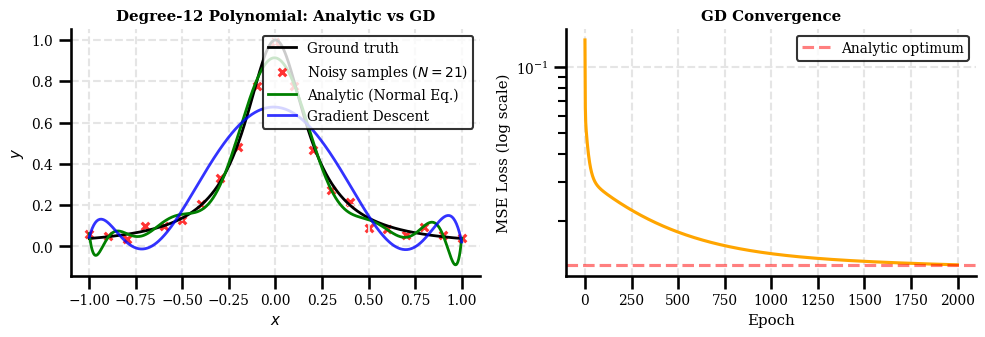

In [107]:
# --- Compare GD solution to the analytic solution ---
degree = model_gd.degree
theta_analytic = analytic_poly_fit(x_train, y_train, model_gd.degree)
y_analytic = poly_eval(x_plot, theta_analytic)

with torch.no_grad():
    x_plot_t = torch.tensor(x_plot, dtype=torch.float32)
    y_gd = model_gd(x_plot_t).numpy()

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

# Left: fits
ax = axes[0]
ax.plot(x_plot, y_true, 'k-', lw=2, label='Ground truth')
ax.scatter(x_train, y_train, s=30, alpha=0.8, color='r', marker='x', label=f'Noisy samples ($N={N}$)')
ax.plot(x_plot, y_analytic, 'g-', lw=2, label='Analytic (Normal Eq.)')
ax.plot(x_plot, y_gd, 'b-', lw=2, alpha=0.8, label='Gradient Descent')
ax.set_xlabel('$x$'); ax.set_ylabel('$y$')
ax.set_title(f'Degree-{degree} Polynomial: Analytic vs GD'); ax.legend()

# Right: loss curve
ax = axes[1]
ax.semilogy(loss_history_gd, color='orange')
ax.axhline(y=loss_history_gd[-1], color='red', ls='--', alpha=0.5, label='Analytic optimum')
ax.set_xlabel('Epoch'); ax.set_ylabel('MSE Loss (log scale)')
ax.set_title('GD Convergence'); ax.legend()

plt.tight_layout(); plt.show()

**Key takeaway:** This loss function is a *convex function* and converges to the same minimum loss as the normal equations, although somewhat slowly.  The analytic approach finds it directly, while gradient descent makes iteratively better approximations. For neural networks (non-convex), no closed form exists, so iterative methods are our only option.

## GD to SGD: The Batch Parameter

Full-batch GD computes the gradient over **all** $N$ samples. When $N$ is large for high dimension data like images, this might not fit in memory and be expensive to compute. Instead we use an unbiased estimator of the gradient by sampling a random mini-batch of size $B$ at each iteration.

**Stochastic Gradient Descent (SGD)** replaces the full gradient with an estimate from a random mini-batch of size $B$:

$$\nabla_\theta \mathcal{L} \;\approx\; \frac{1}{B} \sum_{i \in \mathcal{B}} \nabla_\theta \ell_i(\theta)$$

Because the samples $(x_i, y_i)$ are drawn **i.i.d.**, this is an *unbiased* estimate of the true gradient. The trade-off:
- **Smaller $B$** $\Rightarrow$ noisier gradient, but cheaper per step and better at escaping shallow local minima.
- **Larger $B$** $\Rightarrow$ smoother gradient, approaches full GD as $B \to N$.

For non-convex problems, SGD has the added benefit of helping to escape local minima due to the noise in the gradient estimates.

PyTorch's `DataLoader` handles shuffling and batching automatically.

In [108]:
from torch.utils.data import DataLoader

torch.manual_seed(67)  # For reproducibility
batch_size = 3    # Mini-batch size
train_dataset = RungeDataset(x_train, y_train)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
model_sgd = PolynomialModel(degree = 12)
criterion = nn.MSELoss()
optimizer_sgd = torch.optim.SGD(model_sgd.parameters(), lr=0.2)

# --- Mini-batch training loop ---
num_epochs_sgd = 2000  # fewer epochs, but more updates per epoch
loss_history_sgd = []

for epoch in range(num_epochs_sgd):
    epoch_loss = 0.0
    for x_batch, y_batch in train_loader:
        y_pred = model_sgd(x_batch)
        loss = criterion(y_pred, y_batch)

        optimizer_sgd.zero_grad()
        loss.backward()
        optimizer_sgd.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    loss_history_sgd.append(avg_loss)
    if (epoch + 1) % 200 == 0:
        print(f"Epoch {epoch+1:>4d}/{num_epochs_sgd}  |  Avg Batch Loss = {avg_loss:.6f}")

print(f"\nFinal SGD loss: {loss_history_sgd[-1]:.6f}")

Epoch  200/2000  |  Avg Batch Loss = 0.019687
Epoch  400/2000  |  Avg Batch Loss = 0.015911
Epoch  600/2000  |  Avg Batch Loss = 0.015079
Epoch  800/2000  |  Avg Batch Loss = 0.017552
Epoch 1000/2000  |  Avg Batch Loss = 0.014394
Epoch 1200/2000  |  Avg Batch Loss = 0.015949
Epoch 1400/2000  |  Avg Batch Loss = 0.012257
Epoch 1600/2000  |  Avg Batch Loss = 0.014488
Epoch 1800/2000  |  Avg Batch Loss = 0.012434
Epoch 2000/2000  |  Avg Batch Loss = 0.013060

Final SGD loss: 0.013060


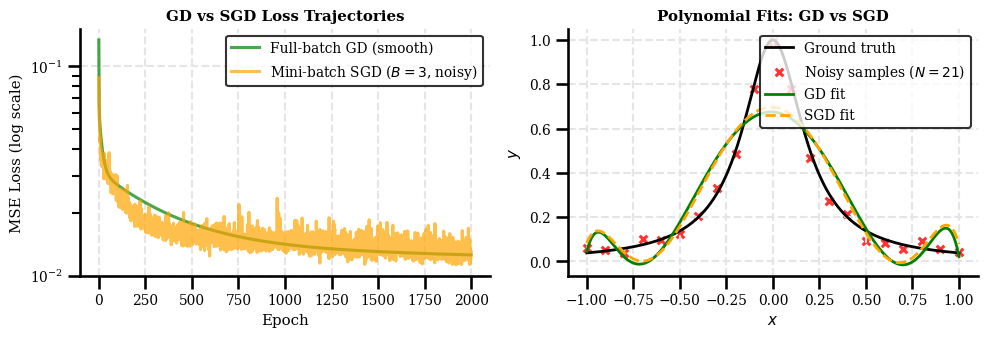

In [109]:
# --- Compare GD vs SGD trajectories ---
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

# Left: loss trajectories
ax = axes[0]
# Subsample GD to match SGD epoch count for a fair visual comparison
gd_subsample = np.linspace(0, len(loss_history_gd)-1, len(loss_history_sgd), dtype=int)
ax.semilogy(loss_history_gd, color='green', alpha=0.7, label='Full-batch GD (smooth)')
ax.semilogy(loss_history_sgd, color='orange', alpha=0.7, label=f'Mini-batch SGD ($B={batch_size}$, noisy)')
ax.set_xlabel('Epoch'); ax.set_ylabel('MSE Loss (log scale)')
ax.set_title('GD vs SGD Loss Trajectories'); ax.legend()

# Right: resulting fits
ax = axes[1]
with torch.no_grad():
    y_sgd = model_sgd(x_plot_t).numpy()

ax.plot(x_plot, y_true, 'k-', lw=2, label='Ground truth')
ax.scatter(x_train, y_train, s=30, alpha=0.8, color='r', marker='x', label=f'Noisy samples ($N={N}$)')
ax.plot(x_plot, y_gd, 'g-', lw=2, label='GD fit')
ax.plot(x_plot, y_sgd, color='orange', lw=2, ls='--', label='SGD fit')
ax.set_xlabel('$x$'); ax.set_ylabel('$y$')
ax.set_title('Polynomial Fits: GD vs SGD'); ax.legend()

plt.tight_layout(); plt.show()

# Moving to Neural Networks: Single-Layer Perceptron (SLP)

A polynomial of degree $n$ has $n+1$ parameters and a fixed set of basis functions $\{1, x, x^2, \ldots, x^n\}$. To approximate *arbitrary* functions, we need a more flexible model. Neural networks learn the basis functions as well as the coefficients. The simplest such model is the **Single-Layer Perceptron (SLP)**:

$$\mathbf{\hat y} = \mathbf{Q}\,\sigma(\mathbf{W}\mathbf{x} + \mathbf{b})$$

where:
- $H$ is the dimension of the hidden layer (number of basis functions),
- $\mathbf{W} \in \mathbb{R}^{H \times 1}$, $\mathbf{b} \in \mathbb{R}^{H}$ are the *input* weights and biases,
- $\sigma$ is a nonlinear **activation function** (e.g., $\tanh$, ReLU),
- $\mathbf{Q} \in \mathbb{R}^{1 \times H}$ are the *output* weights,


**Why is $\sigma$ necessary?** Without it, $\mathbf{Q}(\mathbf{W}\mathbf{x} + \mathbf{b})$ collapses to a linear function regardless of $H$. The activation $\sigma$ introduces nonlinearity, giving the network its expressive power. By the **Universal Approximation Theorem**, a single hidden layer with enough units can approximate any continuous function on a compact set (existence). This does not guarantee that gradient descent will find the optimal parameters.

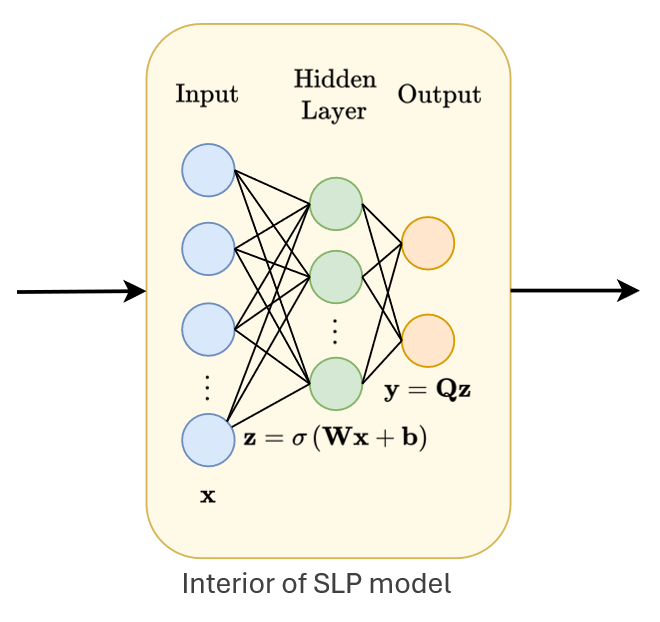

In [110]:
class SLP(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1):
        super(SLP, self).__init__()
        
        self.wx_plus_b = nn.Linear(input_dim, hidden_dim)
        self.sigma = nn.Tanh()
        self.q = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # The split is very evident here:
        z = self.wx_plus_b(x)  
        h = self.sigma(z)     
        y = self.q(h)
        return y
    
model = SLP()
print(model)

SLP(
  (wx_plus_b): Linear(in_features=1, out_features=64, bias=True)
  (sigma): Tanh()
  (q): Linear(in_features=64, out_features=1, bias=True)
)


### SLP Training Loop
Note that the `DataLoader` is used here to provide mini-batches for training. The training samples are dimension `(N,1)` for batch size `N`.

In [111]:
# --- Train the SLP ---
torch.manual_seed(42)
hidden_dim = 64
model_slp = SLP(input_dim=1, hidden_dim=64, output_dim=1)
batch_size = 10

optimizer_slp = torch.optim.Adam(model_slp.parameters(), lr=0.02) 
criterion = nn.MSELoss()

dataset = RungeDataset(x_train, y_train)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

num_epochs_slp = 2500
loss_history_slp = []

for epoch in range(num_epochs_slp):
    # Forward pass to compute y
    for x_batch, y_batch in train_loader:
        x_train_2d = x_batch
        y_train_2d = y_batch
        y_pred = model_slp(x_train_2d)
        loss = criterion(y_pred, y_train_2d) 

        # Compute the gradient and update the parameters
        optimizer_slp.zero_grad()
        loss.backward()
        optimizer_slp.step()

    loss_history_slp.append(loss.item())
    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1:>5d}/{num_epochs_slp}  |  Loss = {loss.item():.6f}")

print(f"\nFinal SLP loss: {loss_history_slp[-1]:.6f}")

Epoch   500/2500  |  Loss = 0.003931
Epoch  1000/2500  |  Loss = 0.006409
Epoch  1500/2500  |  Loss = 0.004352
Epoch  2000/2500  |  Loss = 0.000416
Epoch  2500/2500  |  Loss = 0.000242

Final SLP loss: 0.000242


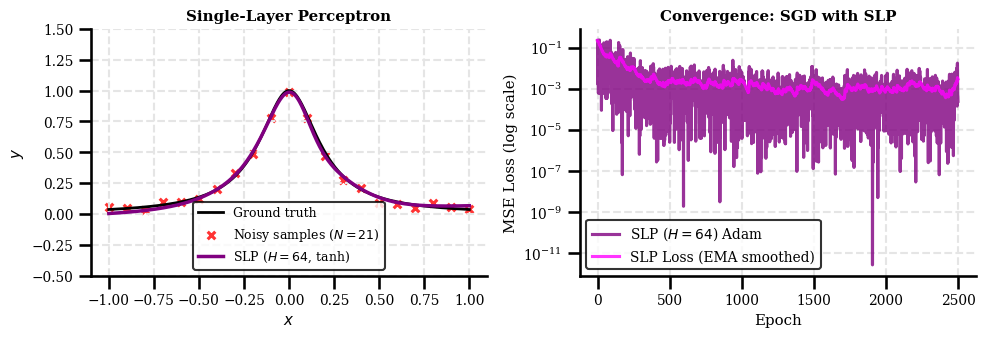

In [112]:
# --- Final comparison: Polynomial vs SLP ---
with torch.no_grad():
    x_plot_2d = x_plot_t.unsqueeze(1) 
    y_slp = model_slp(x_plot_2d).squeeze().numpy()
    
# EMA the loss to get trendline
def ema(data, alpha=0.1):
    ema_data = []
    ema_value = data[0]
    for x in data:
        ema_value = alpha * x + (1 - alpha) * ema_value
        ema_data.append(ema_value)
    return ema_data

smoothed_loss_slp = ema(loss_history_slp, alpha=0.05)

fig, axes = plt.subplots(1, 2, figsize=(10,3.5))

# Left: fits
ax = axes[0]
ax.plot(x_plot, y_true, 'k-', lw=2, label='Ground truth')
ax.scatter(x_train, y_train, s=30, alpha=0.8, color='r', marker='x', label=f'Noisy samples ($N={N}$)')
ax.plot(x_plot, y_slp, color='purple', lw=2.5, label=f'SLP ($H={hidden_dim}$, tanh)')
ax.set_xlabel('$x$'); ax.set_ylabel('$y$')
ax.set_ylim(-0.5, 1.5)
ax.set_title('Single-Layer Perceptron'); ax.legend(fontsize=9)

# Right: loss curves
ax = axes[1]
ax.semilogy(loss_history_slp, color='purple', alpha=0.8, label=f'SLP ($H={hidden_dim}$) Adam')
ax.semilogy(smoothed_loss_slp, color='magenta', alpha=0.8, label='SLP Loss (EMA smoothed)')
ax.set_xlabel('Epoch'); ax.set_ylabel('MSE Loss (log scale)')
ax.set_title('Convergence: SGD with SLP'); ax.legend()

plt.tight_layout(); plt.show()

**Key takeaway:** The single-layer perceptron with $\tanh$ activation fits the Runge function without the edge oscillations. It achieves this with learned, adaptive basis functions $\sigma(w_j x + b_j)$ rather than the fixed monomials $x^k$. This is the conceptual foundation for all deep learning models.

# Deep Learning: Multi-Layer Perceptron (MLP)
The SLP is a special case of a more general architecture called the **Multi-Layer Perceptron (MLP)**, which consists of multiple layers of nonlinear transformations. Deep learning models have more than one hidden layer, allowing them to learn increasingly complex representations of the data. Each layer follows the same pattern of linear transformation followed by a nonlinearity. The hidden dimensions can be arbitrarily large or small, as well as the number of layers. The output of one layer becomes the input to the next:

\begin{align*}
    \mathbf{x}_1 &= \mathbf{Q}_1 \sigma(\mathbf{W}_1 \mathbf{x}_0 + \mathbf{b}_1) \\
    \mathbf{x}_2 &= \mathbf{Q}_2 \sigma(\mathbf{W}_2 \mathbf{x}_1 + \mathbf{b}_2) \\
    &\vdots \\
    \mathbf{x}_N &= \mathbf{Q}_N \sigma(\mathbf{W}_N \mathbf{x}_{N-1} + \mathbf{b}_N)
\end{align*}

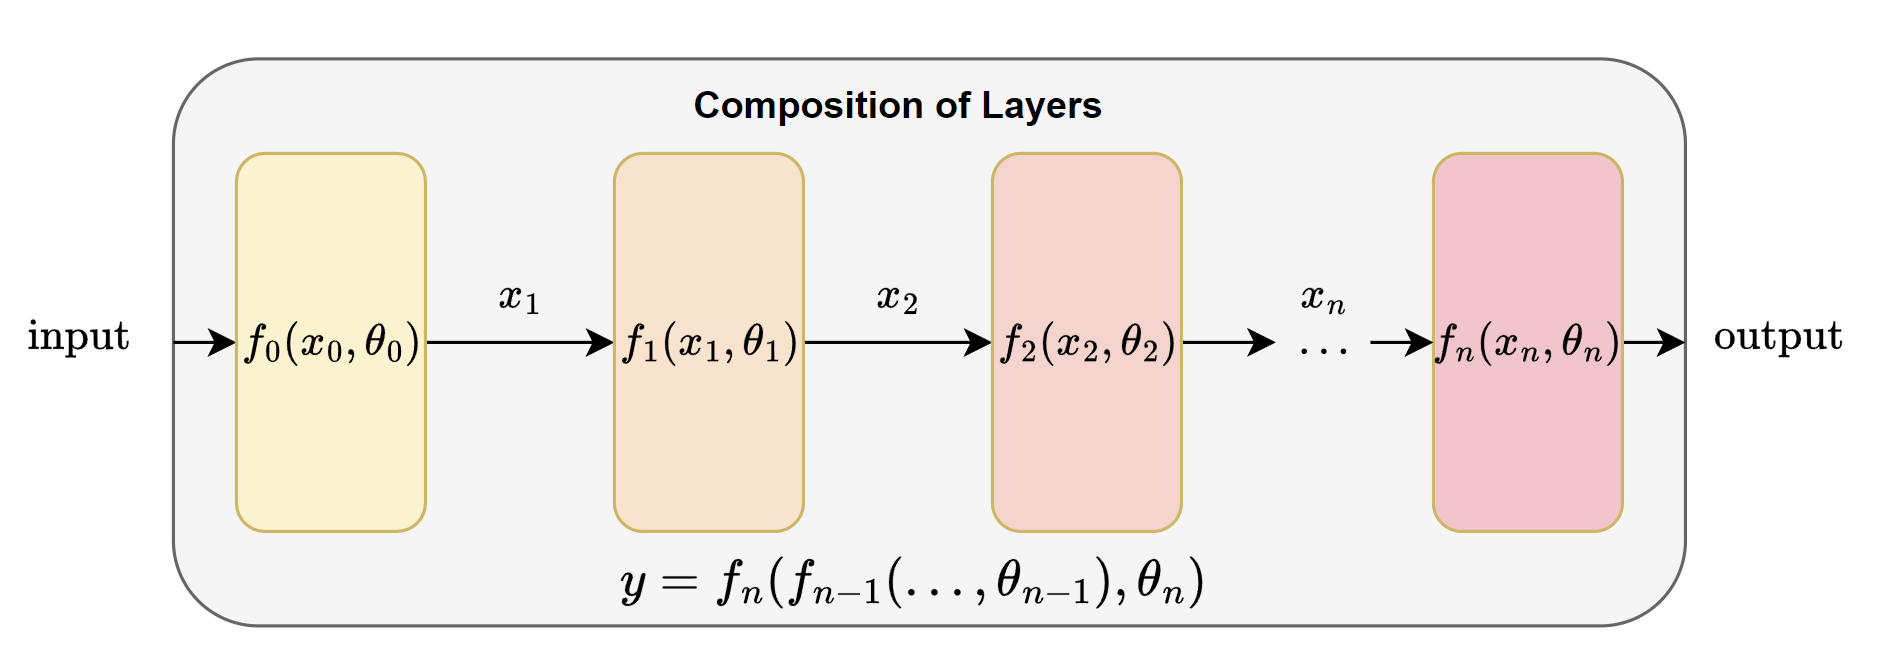


In [113]:
import torch
import torch.nn as nn
from typing import Type

class MLP(nn.Module):
    """A standard Multi-Layer Perceptron (MLP) with configurable depth and components.

    This implementation serves as a flexible workhorse for regression and classification
    tasks. It supports arbitrary depth, width, and optional normalization (LayerNorm).
    Normalization is important for stability in deeper networks or Neural ODE contexts.

        Input -> [Linear -> Norm? -> Activation] x (num_layers - 1) -> Linear -> Output

    Args:
        input_dim (int): Dimensionality of the input features.
        output_dim (int): Dimensionality of the output features.
        hidden_dim (int): Number of units in each hidden layer.
        num_layers (int): Total number of linear transformations (weight matrices).
            Must be at least 1.
        act_fn (Type[nn.Module] or Callable): The activation function class or factory 
            to use (e.g., nn.ReLU, nn.Tanh). Defaults to nn.ReLU.
        use_norm (bool): If True, applies Layer Normalization after every linear
            layer except the final output layer. Defaults to False.
        dropout (float): Dropout probability applied after activation. Defaults to 0.0.

    Example:
        >>> # Create a 3-layer MLP for regression
        >>> model = MLP(input_dim=10, output_dim=1, hidden_dim=64, num_layers=3)
        )
    """

    def __init__(
        self, 
        input_dim: int, 
        output_dim: int, 
        hidden_dim: int = 64, 
        num_layers: int = 3, 
        act_fn: Type[nn.Module] = nn.ReLU, 
        use_norm: bool = False,
        dropout: float = 0.0
    ):
        super(MLP, self).__init__()
        
        if num_layers < 2:
            raise ValueError(f"num_layers must be >= 1, got {num_layers}")

        layers = []
        
        # --Input Layer-- Expand from input_dim to hidden_dim
        layers.append(nn.Linear(input_dim, hidden_dim))
        if use_norm:
            layers.append(nn.LayerNorm(hidden_dim))
        layers.append(act_fn())
        if dropout > 0:
            layers.append(nn.Dropout(dropout))

        # --Hidden Layers-- Repeat hidden_dim -> hidden_dim
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            if use_norm:
                layers.append(nn.LayerNorm(hidden_dim))
            layers.append(act_fn())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))

        # -- Output Layer-- Final linear layer from hidden_dim to output_dim
        layers.append(nn.Linear(hidden_dim, output_dim))

        # Register all layers as a single sequential container
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Network forward pass."""
        return self.net(x)

Now we revist the Runge function with a 3-layer MLP.

In [114]:
# --- Train the SLP ---
torch.manual_seed(42)
hidden_dim = 32
model_mlp = MLP(input_dim=1, hidden_dim=hidden_dim, output_dim=1, num_layers=3, act_fn=nn.Tanh)
batch_size = 10

optimizer_mlp = torch.optim.Adam(model_mlp.parameters(), lr=0.0005) 
criterion = nn.MSELoss()

dataset = RungeDataset(x_train, y_train)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

num_epochs_mlp = 3000
loss_history_mlp = []

for epoch in range(num_epochs_mlp):
    # Forward pass to compute y
    for x_batch, y_batch in train_loader:
        x_train_2d = x_batch
        y_train_2d = y_batch
        y_pred = model_mlp(x_train_2d)
        loss = criterion(y_pred, y_train_2d) 

        # Compute the gradient and update the parameters
        optimizer_mlp.zero_grad()
        loss.backward()
        optimizer_mlp.step()

    loss_history_mlp.append(loss.item())
    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1:>5d}/{num_epochs_mlp}  |  Loss = {loss.item():.6f}")

print(f"\nFinal MLP loss: {loss_history_mlp[-1]:.6f}")

Epoch   500/3000  |  Loss = 0.000426
Epoch  1000/3000  |  Loss = 0.003581
Epoch  1500/3000  |  Loss = 0.000468
Epoch  2000/3000  |  Loss = 0.000036
Epoch  2500/3000  |  Loss = 0.000007
Epoch  3000/3000  |  Loss = 0.000008

Final MLP loss: 0.000008


### Compare Results to SLP and Polynomial

Mean Squared Error of MLP: 0.000174
Mean Squared Error of SLP: 0.000301


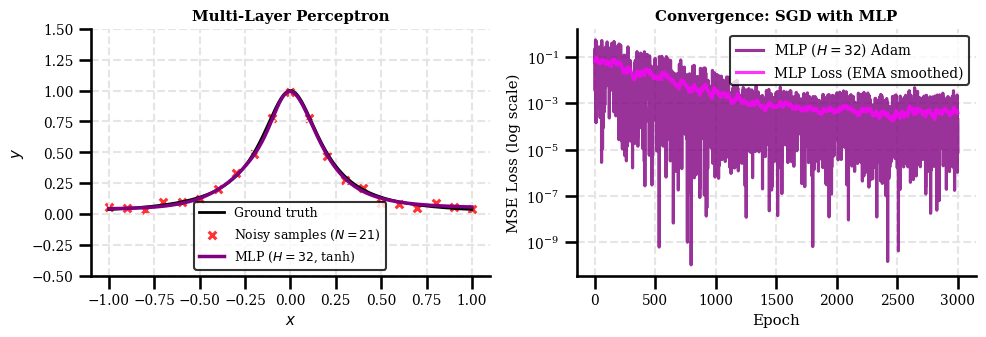

In [115]:
with torch.no_grad():
    x_plot_2d = x_plot_t.unsqueeze(1) 
    y_mlp = model_mlp(x_plot_2d).squeeze().numpy()
    
smoothed_loss_mlp = ema(loss_history_mlp, alpha=0.05)

fig, axes = plt.subplots(1, 2, figsize=(10,3.5))

# Left: fits
ax = axes[0]
ax.plot(x_plot, y_true, 'k-', lw=2, label='Ground truth')
ax.scatter(x_train, y_train, s=30, alpha=0.8, color='r', marker='x', label=f'Noisy samples ($N={N}$)')
ax.plot(x_plot, y_mlp, color='purple', lw=2.5, label=f'MLP ($H={hidden_dim}$, tanh)')
ax.set_xlabel('$x$'); ax.set_ylabel('$y$')
ax.set_ylim(-0.5, 1.5)
ax.set_title('Multi-Layer Perceptron'); ax.legend(fontsize=9)

# Right: loss curves
ax = axes[1]
ax.semilogy(loss_history_mlp, color='purple', alpha=0.8, label=f'MLP ($H={hidden_dim}$) Adam')
ax.semilogy(smoothed_loss_mlp, color='magenta', alpha=0.8, label='MLP Loss (EMA smoothed)')
ax.set_xlabel('Epoch'); ax.set_ylabel('MSE Loss (log scale)')
ax.set_title('Convergence: SGD with MLP'); ax.legend()

# Compare error of MLP vs SLP
error_mlp = np.mean((y_mlp - y_true) ** 2)
print(f"Mean Squared Error of MLP: {error_mlp:.6f}")
error_slp = np.mean((y_slp - y_true) ** 2)
print(f"Mean Squared Error of SLP: {error_slp:.6f}")

plt.tight_layout(); plt.show()

---
## Summary

| Phase | Method | Key Idea |
|-------|--------|----------|
| 1 | Runge function | High-degree interpolation overfits (oscillates at edges) |
| 2 | Normal Equation | Closed-form $\theta^* = (X^\top X)^{-1}X^\top y$ — fast but limited to linear models |
| 3 | Gradient Descent | Iterative: same result as Normal Eq. for convex loss, but scales to any differentiable model |
| 4 | SGD + DataLoader | Mini-batch gradients: unbiased estimate, cheaper per step, noisy, helps with finding non local minima |
| 5 | Single-Layer Perceptron | Learned nonlinear basis $\sigma(Wx+b)$ avoids polynomial oscillation |
| 6 | Multi-Layer Perceptron | Multiple layers of nonlinear transformations learn hierarchical features |

---
## Bonus: Training a Handwritten Digits Classifier

**Data:** MNIST handwritten digits dataset (10 classes, 28x28 grayscale images)
**Model:** A 3-layer MLP with ReLU activations
**Loss:** Cross-entropy loss for multi-class classification
**Optimizer:** Adam optimizer with regularization and learning rate scheduling

In [116]:
from torchvision import datasets, transforms

# --- Data ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) 
])

# Download and load the training and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

Training dataset size: 60000


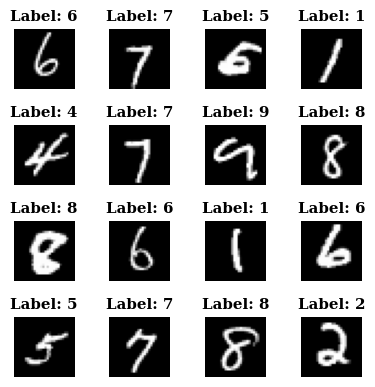

In [117]:
print(f"Training dataset size: {len(train_dataset)}")
batch = next(iter(train_loader))
# First 16 images and labels in the batch
images, labels = batch[0][:16], batch[1][:16]

def show_images_and_labels(images, labels):
    fig, axes = plt.subplots(4, 4, figsize=(4,4))
    for i in range(16):
        ax = axes[i // 4, i % 4]
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_images_and_labels(images, labels)

In [118]:
# --- Model(3-Layer MLP) ---
class MNIST_MLP(nn.Module):
    def __init__(self):
        super(MNIST_MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(28 * 28, 512),  # Input Layer (784 -> 512)
            nn.ReLU(),
            nn.Linear(512, 256),      # Hidden Layer (512 -> 256)
            nn.ReLU(),
            nn.Linear(256, 10)        # Output Layer (256 -> 10 classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers(x)
        return logits # Logits are raw scores for each class label likelihood

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MNIST_MLP().to(device)

# --- Loss and Optimizer ---
# Loss: Cross Entropy for multi-class classification
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Scheduler: Decays the learning rate of each parameter group by gamma every step_size epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# --- Train ---
epochs = 5
print(f"Training on {device}...")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Update Learning Rate
    scheduler.step()
    
    # --- Quick Evaluation after each epoch ---
    model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            
    accuracy = 100 * correct / len(test_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {running_loss/len(train_loader):.4f} | Test Accuracy: {accuracy:.2f}%")

print("Training Complete.")

Training on cuda...
Epoch [1/5] | Loss: 0.2252 | Test Accuracy: 96.65%
Epoch [2/5] | Loss: 0.0879 | Test Accuracy: 97.33%
Epoch [3/5] | Loss: 0.0577 | Test Accuracy: 97.86%
Epoch [4/5] | Loss: 0.0230 | Test Accuracy: 98.30%
Epoch [5/5] | Loss: 0.0159 | Test Accuracy: 98.40%
Training Complete.


## Show Good and Bad Classifications

In [119]:
model.eval()
correct_images, correct_labels = [], []
wrong_images, wrong_labels, wrong_preds = [], [], []

# We'll use these to track the actual count of images
n_c, n_w = 0, 0

# Collect good and bad examples of predictions from the test set (unseen data)
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        
        is_correct = (preds == lbls)
        is_wrong = ~is_correct
        
        # Collect Correct
        if n_c < 8:
            c_slice = imgs[is_correct]
            correct_images.append(c_slice)
            correct_labels.append(lbls[is_correct])
            n_c += len(c_slice)
            
        # Collect Wrong
        if n_w < 8:
            w_slice = imgs[is_wrong]
            wrong_images.append(w_slice)
            wrong_labels.append(lbls[is_wrong])
            wrong_preds.append(preds[is_wrong])
            n_w += len(w_slice)
            
        if n_c >= 8 and n_w >= 8:
            break

# STAGE 2: Concatenate and force exactly 8
c_imgs = torch.cat(correct_images)[:8].cpu()
w_imgs = torch.cat(wrong_images)[:8].cpu()

c_labels = torch.cat(correct_labels)[:8].cpu()
w_labels = torch.cat(wrong_labels)[:8].cpu()
w_preds = torch.cat(wrong_preds)[:8].cpu()

# Final combined tensor: exactly 16 images
all_images = torch.cat([c_imgs, w_imgs]) 
print(f"Final shape: {all_images.shape}") # Should be [16, 1, 28, 28]

Final shape: torch.Size([16, 1, 28, 28])


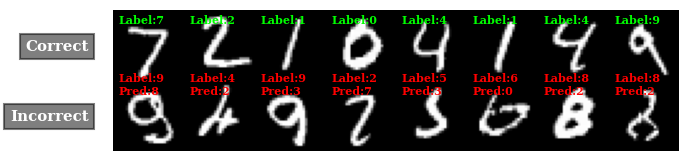

In [120]:
import einops
import matplotlib.pyplot as plt
grid = einops.rearrange(all_images, '(r c) 1 h w -> (r h) (c w)', r=2, c=8)

plt.figure(figsize=(7, 2.5))
plt.imshow(grid, cmap='gray')
plt.axis('off')

# 4. Labeling the rows and individual tiles
for i in range(2):
    row_y_center = i * 28 + 14
    row_label = "Correct" if i == 0 else "Incorrect"
    plt.text(-10, row_y_center, row_label, color='white', weight='bold', 
             ha='right', va='center', bbox=dict(facecolor='black', alpha=0.5))
    
    for j in range(8):
        idx = i * 8 + j
        x_pos = j * 28 + 2
        y_pos = i * 28 + 5
        
        if i == 0: # Correct row
            plt.text(x_pos, y_pos, f"Label:{c_labels[j].item()}", color='lime', fontsize=8, weight='bold')
        else: # Wrong row
            txt = f"Label:{w_labels[j].item()}\nPred:{w_preds[j].item()}"
            plt.text(x_pos, y_pos, txt, color='red', fontsize=8, weight='bold')

plt.tight_layout()
plt.show()